## Detalle sobre este notebook (fv_iteraperiodos_para_max_betweenness):
* **OBJETIVO:** Dado un aspecto y un % de nodos a considerar, se itera en los períodos 14 al 21, y se informa el período en que el betweenness es máximo

#### Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from networkx.algorithms import community
import community as community_louvain


#### Cargar df_5_extended

In [2]:
df_5_extended = pd.read_excel('df_5_extended.xlsx')
df_5_extended.head()

,countryname,ventana_5,per101,per102,per103,per104,per105,per106,per107,per108,...,per606_1,per606_2,per607_1,per607_2,per607_3,per608_1,per608_2,per608_3,per703_1,per703_2
0,Albania,15,3.113815,0.00000,1.559835,2.046771,0.331285,1.674371,4.632186,5.169904,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,Albania,16,3.716797,0.00000,0.051879,3.519091,0.015910,0.579077,4.971347,1.981720,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,Albania,17,2.392570,0.00000,0.000000,2.757403,0.026619,0.023948,3.523162,1.452779,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,Argentina,14,0.000000,0.00000,4.619213,0.448618,0.828036,0.338070,2.955090,0.000000,...,7.595332,0.0,0.326532,0.0,0.000000,0.0,0.0,0.0,2.495280,0.0
4,Argentina,16,0.254185,0.02014,0.725611,1.406834,0.100835,1.720736,5.478894,3.932102,...,4.494125,0.0,0.443809,0.0,0.809128,0.0,0.0,0.0,2.573783,0.0


In [3]:
df_5_extended.shape

(1407, 144)

In [4]:
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
df_AD.head()


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [5]:
all_per_variables = [col for col in df_5_extended.columns if col.startswith('per')]
all_per_variables

['per101',
 'per102',
 'per103',
 'per104',
 'per105',
 'per106',
 'per107',
 'per108',
 'per109',
 'per110',
 'per201',
 'per202',
 'per203',
 'per204',
 'per301',
 'per302',
 'per303',
 'per304',
 'per305',
 'per401',
 'per402',
 'per403',
 'per404',
 'per405',
 'per406',
 'per407',
 'per408',
 'per409',
 'per410',
 'per411',
 'per412',
 'per413',
 'per414',
 'per415',
 'per416',
 'per501',
 'per502',
 'per503',
 'per504',
 'per505',
 'per506',
 'per507',
 'per601',
 'per602',
 'per603',
 'per604',
 'per605',
 'per606',
 'per607',
 'per608',
 'per701',
 'per702',
 'per703',
 'per704',
 'per705',
 'per706',
 'per1011',
 'per1012',
 'per1013',
 'per1014',
 'per1015',
 'per1016',
 'per1021',
 'per1022',
 'per1023',
 'per1024',
 'per1025',
 'per1026',
 'per1031',
 'per1032',
 'per1033',
 'per2021',
 'per2022',
 'per2023',
 'per2031',
 'per2032',
 'per2033',
 'per2041',
 'per3011',
 'per3051',
 'per3052',
 'per3053',
 'per3054',
 'per3055',
 'per4011',
 'per4012',
 'per4013',
 'per4014',


In [6]:
len(all_per_variables)

142

### MATRIZ DE ASPECTOS

In [7]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['INMIGRANTES'],
    'var_1': ['per601'],
    'var_2': ['per602'],
    'var_3': [None],  # None indica que no hay una tercera variable para el aspecto
    'var_4': [None]  
}

df_aspectos = pd.DataFrame(data_aspectos)

# Mostrar el DataFrame 'df_aspectos' para verificar su contenido
display(df_aspectos)

,aspecto,var_1,var_2,var_3,var_4
0,INMIGRANTES,per601,per602,None,None


#### Años en cada período

In [8]:
# cargar períodos
df_ventana_5 = pd.read_excel('data/Ventana_5.xlsx')
df_ventana_5

,agno,ventana
0,1920,1
1,1921,1
2,1922,1
3,1923,1
4,1924,1
...,...,...
99,2019,20
100,2020,21
101,2021,21
102,2022,21


#### Calculamos la similaridad tanto con correlación como con distancia euclideana

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import spearmanr
from collections import defaultdict
import itertools


In [10]:
def calcular_similitudes_todos_paises(df, df_aspectos, tipo_similitud, periodo):
    """Calcula la similaridad entre todos los países para un aspecto específico y un período usando Pearson o Euclidean."""
    similarity_results = defaultdict(list)

    # Filtrar el dataframe para el período específico
    df = df[df['ventana_5'] == periodo]
    
    for _, row_aspecto in df_aspectos.iterrows():
        aspecto = row_aspecto['aspecto']
        variables = row_aspecto[['var_1', 'var_2', 'var_3', 'var_4']].dropna().tolist()

        # Filtrar datos de todos los países con las columnas relevantes
        columnas_relevantes = ['countryname', 'ventana_5'] + variables
        df_filtered = df[columnas_relevantes].copy()

        # Calcular similitudes entre todos los pares de países
        for (idx1, row1), (idx2, row2) in itertools.combinations(df_filtered.iterrows(), 2):
            country_period_1 = f"{row1['countryname']}_{row1['ventana_5']}"
            country_data_1 = row1[variables].astype(float)

            country_period_2 = f"{row2['countryname']}_{row2['ventana_5']}"
            country_data_2 = row2[variables].astype(float)

            # Asignar similaridad de cero si uno de los países tiene todos los valores en cero
            if country_data_1.sum() == 0 or country_data_2.sum() == 0:
                similarity = 0  
            else:
                if tipo_similitud == 'pearson':
                    # Calcular la correlación de Pearson
                    corr = country_data_1.corr(country_data_2, method='pearson')
                    # print(f"Pearson/ {aspecto} / {country_period_1} / {country_period_2} / {corr}")
                    similarity = 0 if pd.isna(corr) else abs(corr)
                elif tipo_similitud == 'euclidean':
                    dist = euclidean(country_data_1, country_data_2)
                    similarity = 1 / (1 + dist) if not np.isnan(dist) else 0

            similarity_results[(aspecto, country_period_1, country_period_2)].append(similarity)

    # Convertir a DataFrame
    final_results = {
        key: np.mean(values) for key, values in similarity_results.items()
    }

    df_similarities = pd.DataFrame(
        list(final_results.items()), 
        columns=['Aspecto_Country_Period1_Period2', 'Similarity']
    )
    df_similarities[['Aspecto', 'Country_Period_1', 'Country_Period_2']] = pd.DataFrame(
        df_similarities['Aspecto_Country_Period1_Period2'].tolist(), index=df_similarities.index
    )
    df_similarities.drop('Aspecto_Country_Period1_Period2', axis=1, inplace=True)

    # Eliminar duplicados
    df_similarities = df_similarities.groupby(['Country_Period_1', 'Country_Period_2'], as_index=False).agg({'Similarity': 'mean'})
    
    return df_similarities


#### Generamos las Redes, Comunidades y Métricas de Centralidad

In [15]:
def generar_red_y_calcular_metricas(df_similarity, aspecto, tipo_similitud, porcentaje, periodo):
    """
    Genera una red de similaridad, calcula las métricas de centralidad, 
    y analiza las comunidades detectadas para un aspecto específico.
    """
    resumen = {'Aspecto': aspecto, 'Criterio': tipo_similitud}
    
    # Obtener los años "Desde" y "Hasta" para el período dado
    desde_hasta_df = df_ventana_5[df_ventana_5['ventana'] == periodo]
    desde = desde_hasta_df['agno'].min()
    hasta = desde_hasta_df['agno'].max()
    
    # Filtrar los x% enlaces con mayor similaridad
    df_similarity = df_similarity.sort_values(by='Similarity', ascending=False)
    top_x_percent = int(len(df_similarity) * (porcentaje / 100))
    df_top_similarity = df_similarity.head(top_x_percent)

    # Redondear la similaridad a 4 decimales
    df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
    
    # Crear el grafo
    G = nx.Graph()
    for _, row in df_top_similarity.iterrows():
        nodo_1 = row['Country_Period_1']
        nodo_2 = row['Country_Period_2']
        G.add_edge(nodo_1, nodo_2, weight=row['Similarity'])
    
    # Configuración de colores de los enlaces según la fuerza del enlace
    weights = nx.get_edge_attributes(G, 'weight').values()
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = [cm.coolwarm(norm(weight)) for weight in weights]

    # Visualización de la red de similaridad
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.5, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Red de Similitud - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.show()

    # Clustering y cálculo de métricas de centralidad
    partition = community.louvain_communities(G, weight='weight')
    resumen['Num_Comunidades'] = len(partition)
    print(f"Se identificaron {resumen['Num_Comunidades']} clusters para el aspecto '{aspecto}'.")

    # Visualización del gráfico de comunidades
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    colors = cm.rainbow(np.linspace(0, 1, resumen['Num_Comunidades']))  # Colores para cada comunidad
    for i, comm in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=list(comm), node_size=300, node_color=[colors[i]], label=f'Comunidad {i}')
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=2)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f'Comunidades detectadas - {aspecto}\nPeríodo {periodo} ({desde}-{hasta}) ({porcentaje}% enlaces más fuertes) - {tipo_similitud}')
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, label='Fuerza del Enlace')
    plt.legend(loc="best")
    plt.show()

    # Cálculo de métricas de centralidad
    degree = nx.degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, weight='weight')
    closeness = nx.closeness_centrality(G)
    eigenvector = nx.eigenvector_centrality(G, max_iter=1000)

    # Resumen de centralidades
    centralities = pd.DataFrame({
        'Nodo': list(degree.keys()),
        'Degree_Centrality': list(degree.values()),
        'Betweenness_Centrality': list(betweenness.values()),
        'Closeness_Centrality': list(closeness.values()),
        'Eigenvector_Centrality': list(eigenvector.values())
    })
    
    # Mostrar los top 10 nodos por Betweenness Centrality
    top_betweenness = centralities[['Nodo', 'Betweenness_Centrality']].sort_values(by='Betweenness_Centrality', ascending=False).head(10)
    top_betweenness = top_betweenness.round(4)  # Limitar a 4 decimales
    print(f"\n PERÍODO: {periodo}, % Nodos: {porcentaje} \n ASPECTO: {aspecto}\nTop 10 nodos según Betweenness Centrality:")
    display(top_betweenness)

    # Calcular estadísticas y agregar al resumen
    resumen['Num_Paises'] = len(centralities)
    for metric in ['Degree_Centrality', 'Betweenness_Centrality', 'Closeness_Centrality', 'Eigenvector_Centrality']:
        resumen[f'Promedio_{metric}'] = round(centralities[metric].mean(), 4)
        resumen[f'Std_{metric}'] = round(centralities[metric].std(), 4)
        resumen[f'Max_{metric}'] = round(centralities[metric].max(), 4)

    return resumen, centralities


#### Ejecución


=== Análisis para el período: 14 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


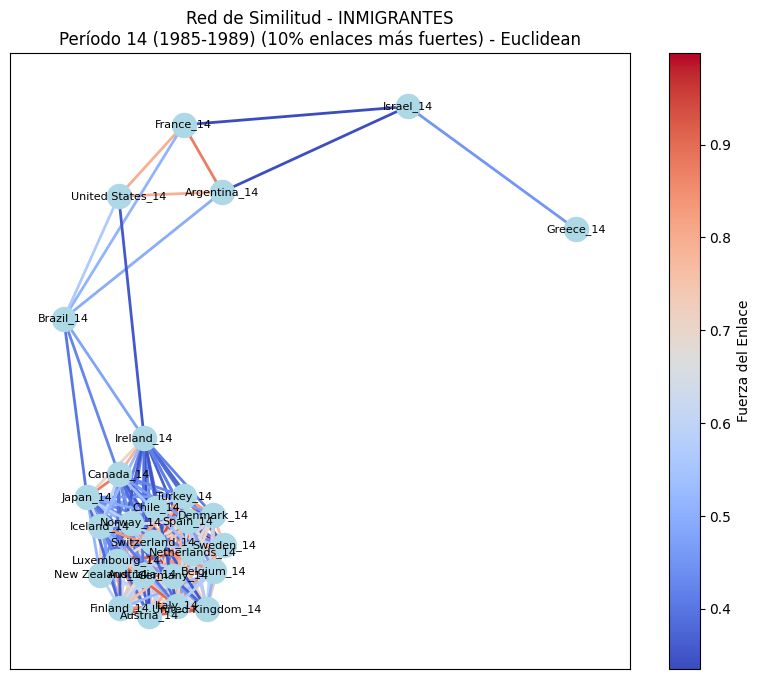

Se identificaron 2 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


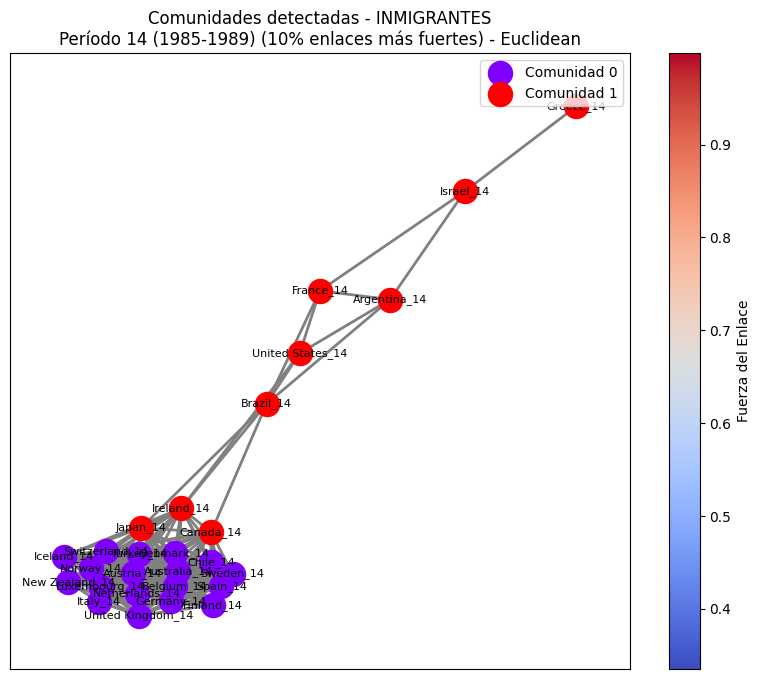


 PERÍODO: 14, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
24,Brazil_14,0.2677
22,Ireland_14,0.2615
17,Canada_14,0.1600
15,Argentina_14,0.1354
26,Israel_14,0.0800
18,Japan_14,0.0800
23,Spain_14,0.0062
16,France_14,0.0062
7,Austria_14,0.0031
20,Iceland_14,0.0031



=== Análisis para el período: 15 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


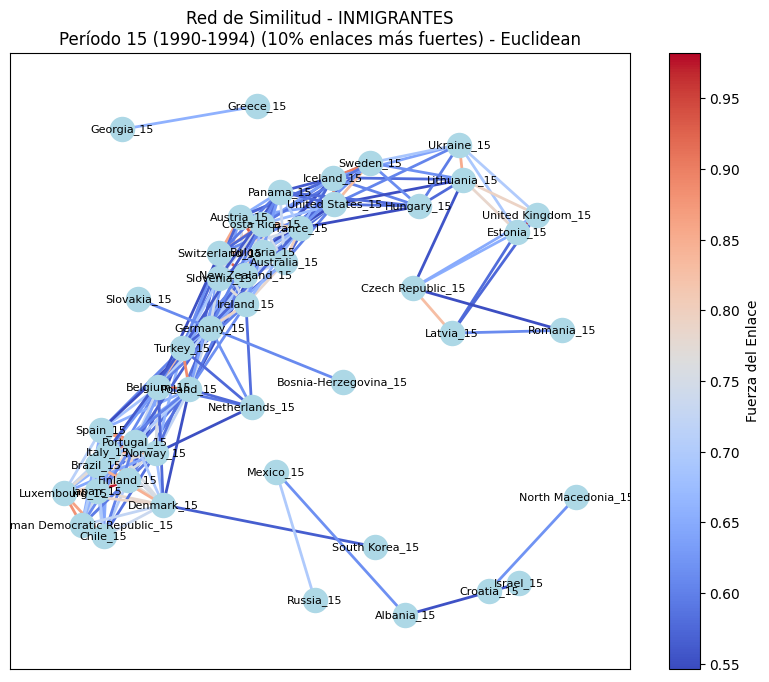

Se identificaron 7 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


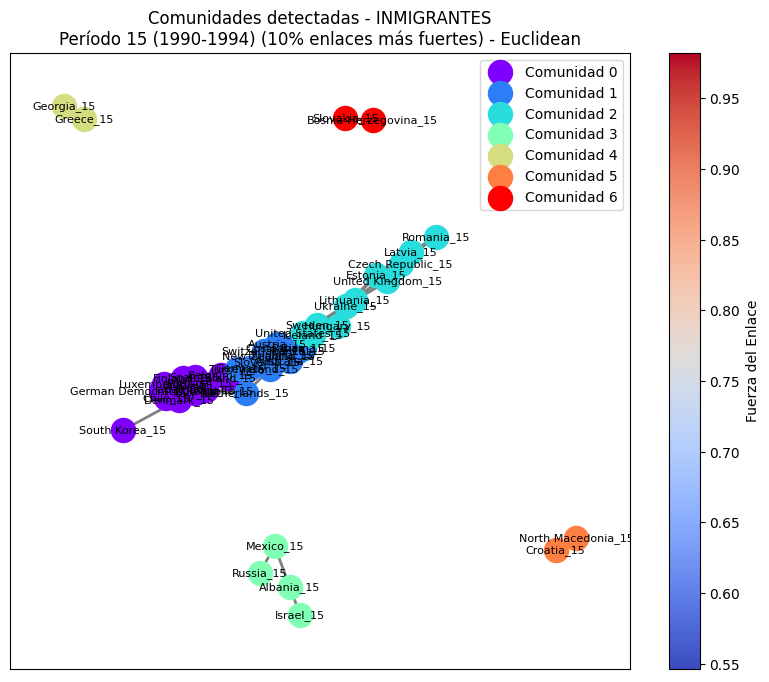


 PERÍODO: 15, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
31,Germany_15,0.0930
26,Ukraine_15,0.0860
15,Poland_15,0.0809
17,United States_15,0.0786
20,Turkey_15,0.0731
42,Hungary_15,0.0638
27,France_15,0.0592
6,Norway_15,0.0578
25,Lithuania_15,0.0574
9,Bulgaria_15,0.0509



=== Análisis para el período: 16 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


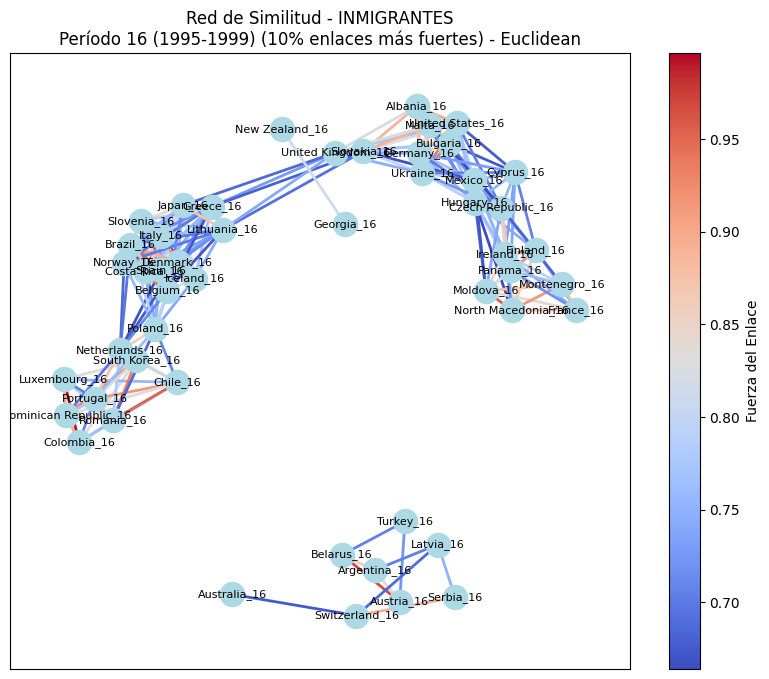

Se identificaron 6 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


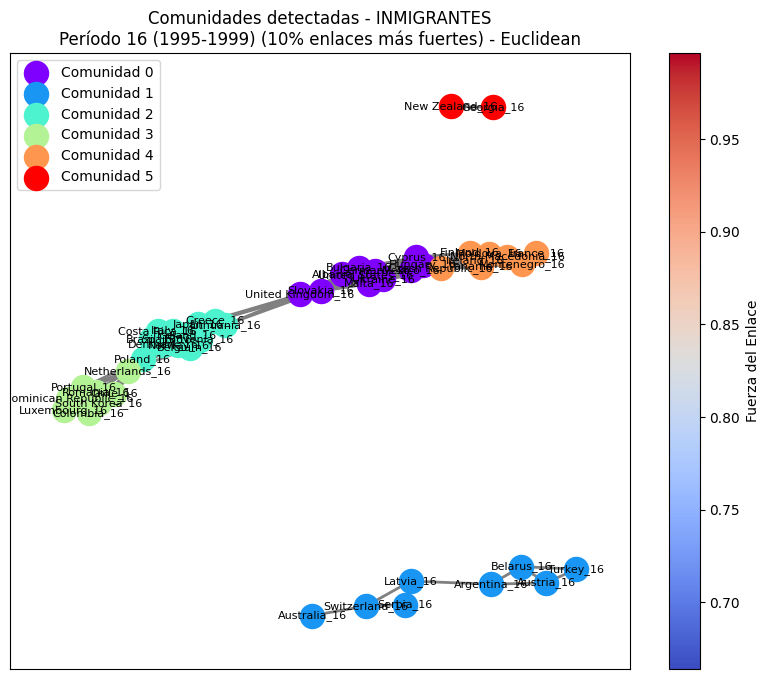


 PERÍODO: 16, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
20,Norway_16,0.1786
34,United Kingdom_16,0.1548
33,Slovakia_16,0.1488
43,Poland_16,0.1310
9,Mexico_16,0.1148
30,Japan_16,0.1029
35,Lithuania_16,0.0978
29,Greece_16,0.0910
36,Germany_16,0.0833
41,Netherlands_16,0.0536



=== Análisis para el período: 17 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


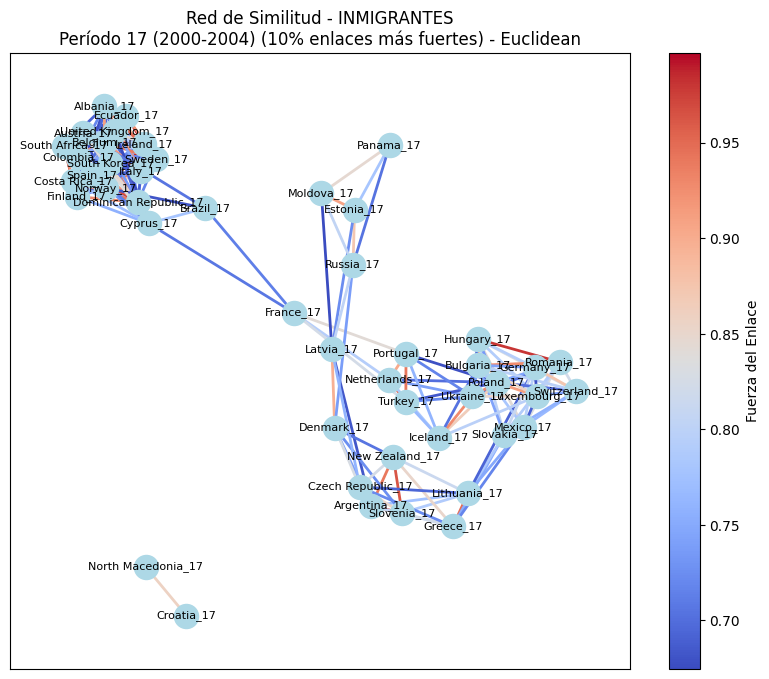

Se identificaron 4 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


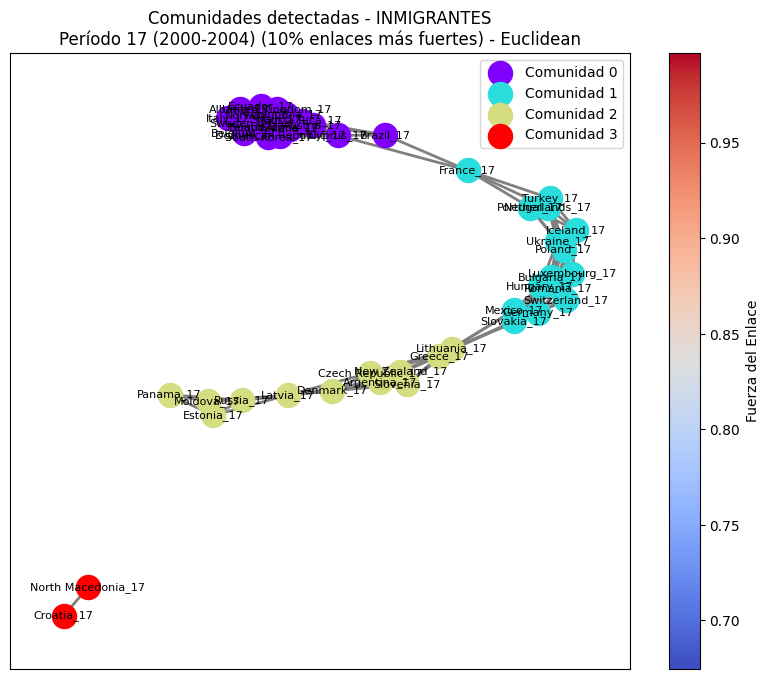


 PERÍODO: 17, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
44,France_17,0.4522
14,Netherlands_17,0.4222
25,Poland_17,0.3188
38,Switzerland_17,0.3111
23,Mexico_17,0.2802
45,Cyprus_17,0.2435
19,Lithuania_17,0.2174
46,Brazil_17,0.1826
40,Czech Republic_17,0.1082
18,Greece_17,0.1014



=== Análisis para el período: 18 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


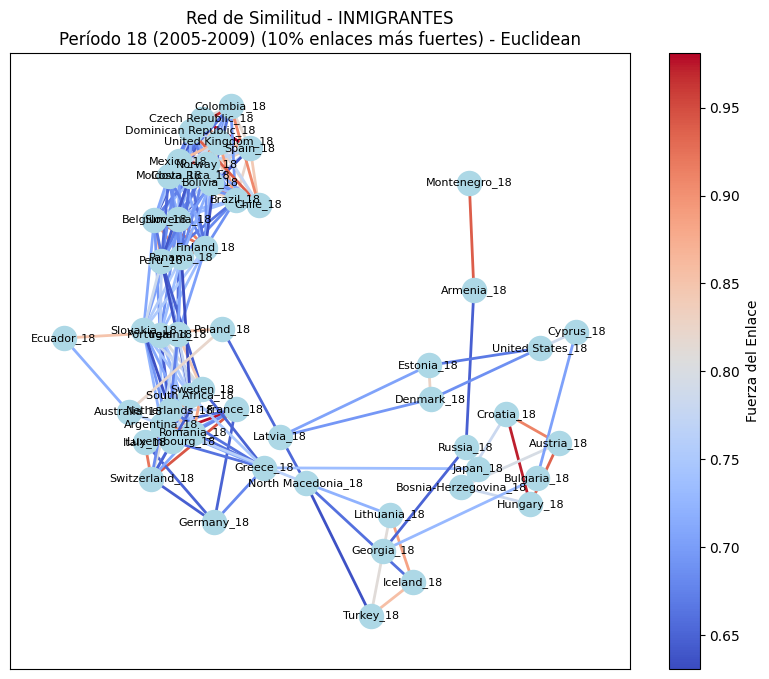

Se identificaron 5 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


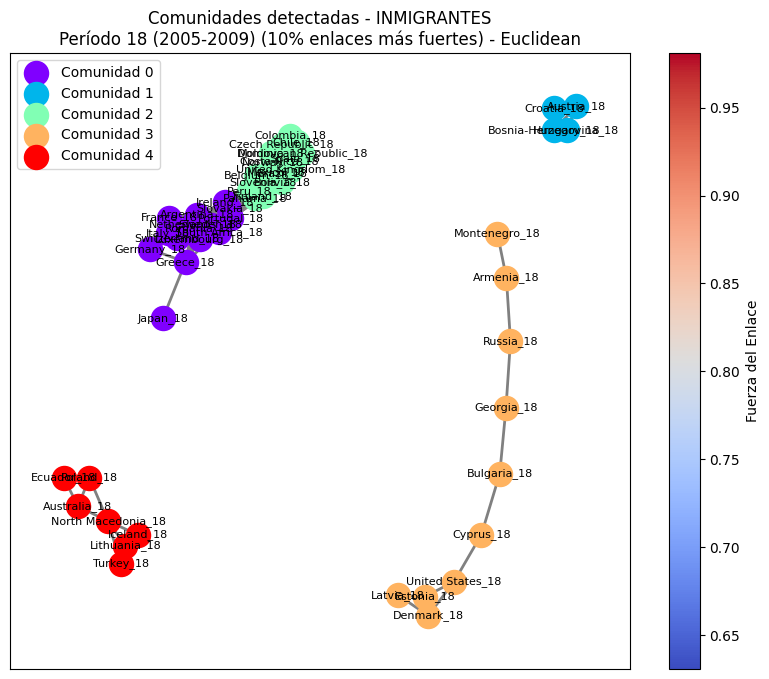


 PERÍODO: 18, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
18,Peru_18,0.0882
29,Moldova_18,0.0588
38,South Africa_18,0.0535
34,Sweden_18,0.0354
3,Slovenia_18,0.0347
46,Greece_18,0.0317
11,Slovakia_18,0.0219
33,Netherlands_18,0.0211
21,Ireland_18,0.0204
30,Argentina_18,0.0189



=== Análisis para el período: 19 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


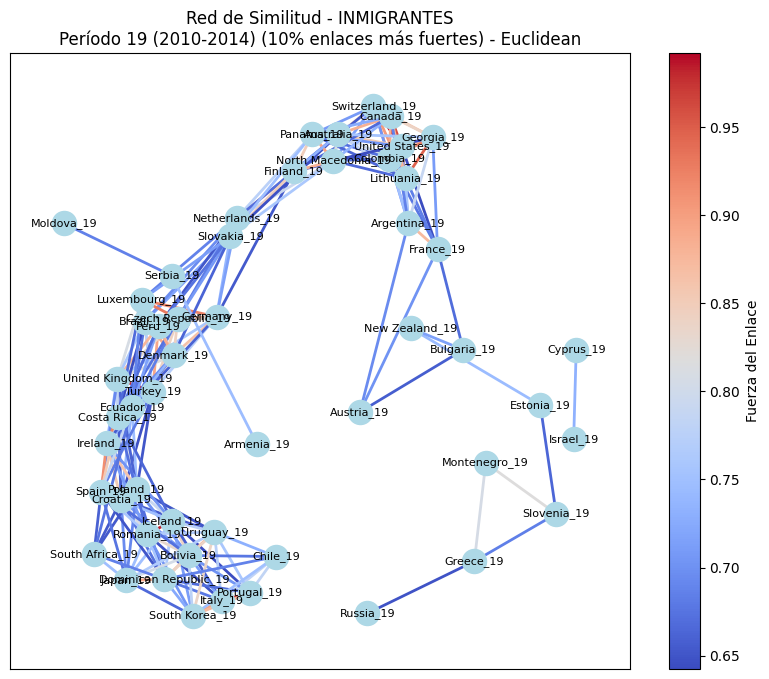

Se identificaron 6 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


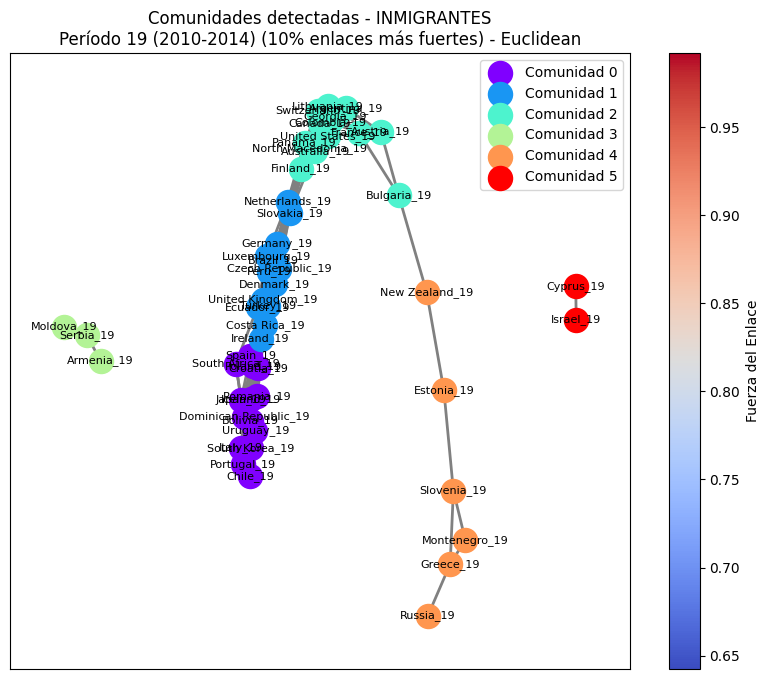


 PERÍODO: 19, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
36,Ecuador_19,0.2200
35,France_19,0.2196
1,United States_19,0.2055
16,Slovakia_19,0.1898
48,Bulgaria_19,0.1882
14,Germany_19,0.1694
32,Finland_19,0.1631
45,New Zealand_19,0.1608
27,Panama_19,0.1561
44,Estonia_19,0.1318



=== Análisis para el período: 20 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


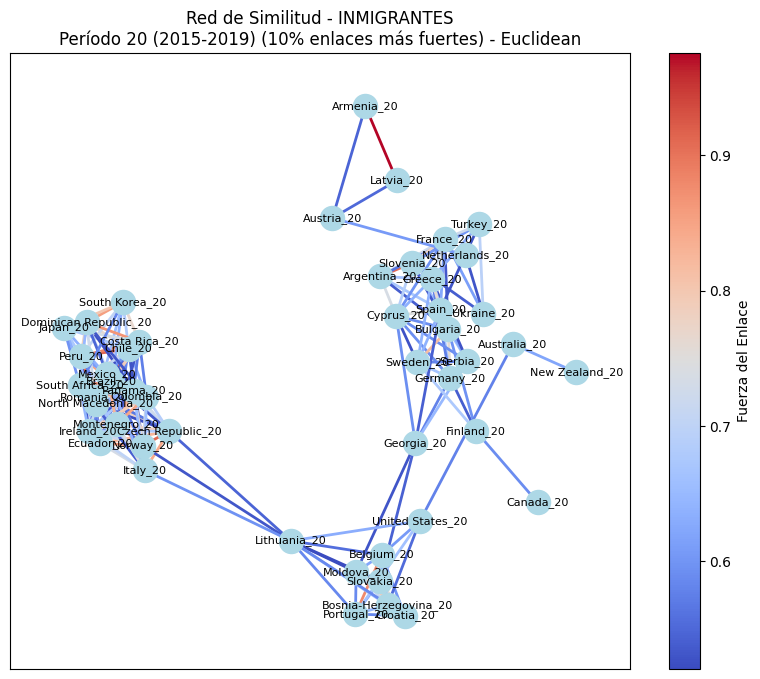

Se identificaron 4 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


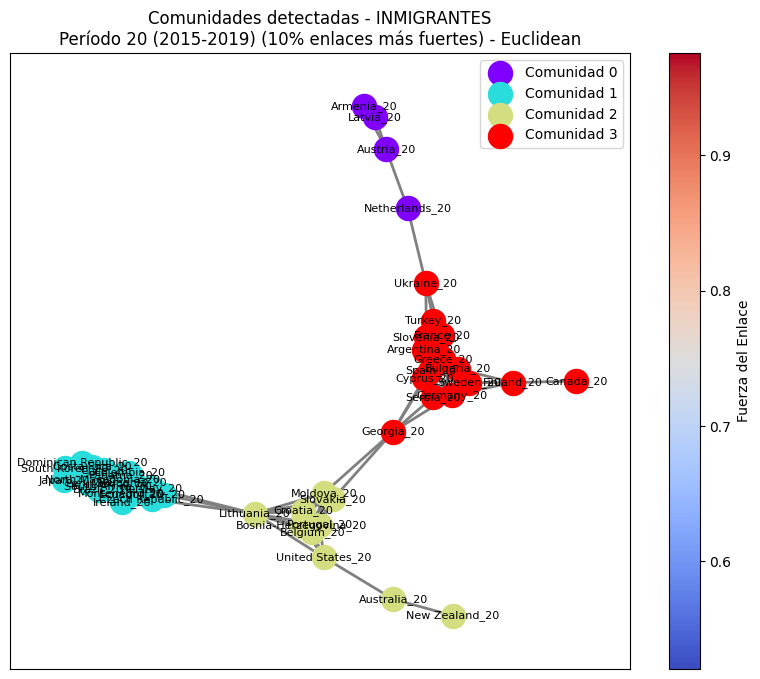


 PERÍODO: 20, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
41,Lithuania_20,0.5504
42,Georgia_20,0.4829
13,Moldova_20,0.4570
6,Czech Republic_20,0.3219
35,Spain_20,0.2525
11,Slovenia_20,0.1711
38,Ukraine_20,0.1591
46,Netherlands_20,0.1221
25,Germany_20,0.0888
45,Austria_20,0.0833



=== Análisis para el período: 21 ===


--- Analizando aspecto: INMIGRANTES ---



/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_similarity['Similarity'] = df_top_similarity['Similarity'].round(4)
/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


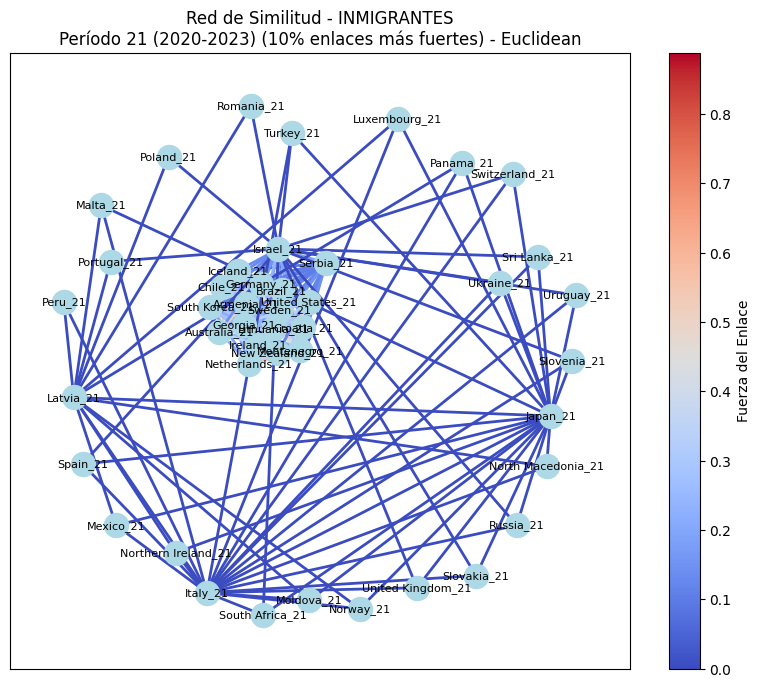

Se identificaron 29 clusters para el aspecto 'INMIGRANTES'.


/var/folders/v8/d2xyhw9n7pb9rqd7k0d1xfsc0000gn/T/ipykernel_5113/2914310538.py:61: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Fuerza del Enlace')


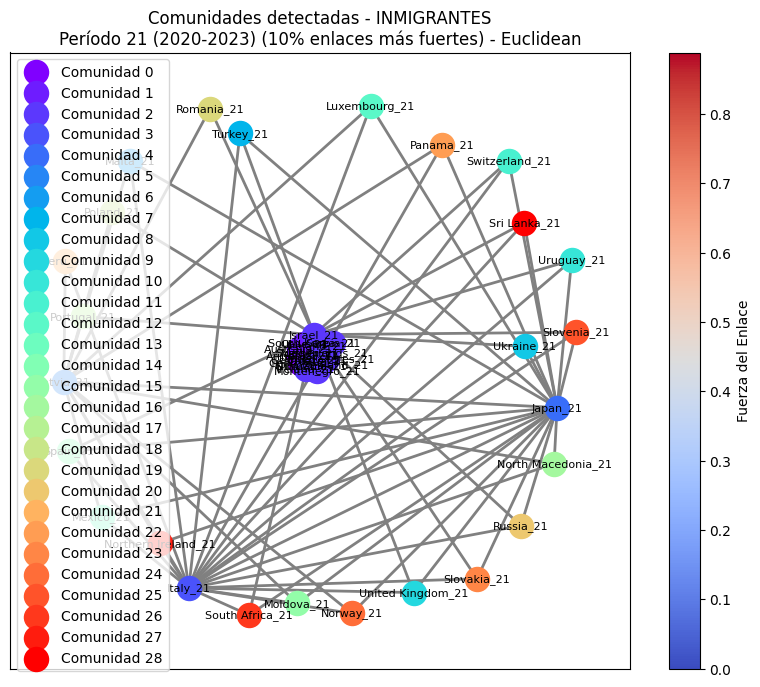


 PERÍODO: 21, % Nodos: 10 
 ASPECTO: INMIGRANTES
Top 10 nodos según Betweenness Centrality:


,Nodo,Betweenness_Centrality
18,Italy_21,256972.7622
19,Japan_21,133754.3569
20,Latvia_21,8553.6034
16,Israel_21,179.8506
35,Russia_21,0.2022
38,Slovakia_21,0.1696
40,Slovenia_21,0.1628
25,Uruguay_21,0.1613
41,South Africa_21,0.1598
43,Sri Lanka_21,0.1591





RESUMEN DE CENTRALIDADES
Período con el máximo promedio de Betweenness Centrality:
Periodo                              21.0000
Promedio_Betweenness_Centrality    9078.7026
Name: 7, dtype: float64


,Periodo,Promedio_Betweenness_Centrality
0,14,0.0373
1,15,0.0209
2,16,0.0273
3,17,0.0716
4,18,0.0099
5,19,0.0503
6,20,0.0681
7,21,9078.7026


In [16]:
# Períodos a iterar
periodos = [14, 15, 16, 17, 18, 19, 20, 21]
porcentaje = 10
pearsonsino = False  # Cambiar a True para incluir análisis de Pearson

# Lista para almacenar los resúmenes de todos los períodos
resumen_periodos = []

# Iterar sobre los períodos
for periodo in periodos:
    print(f"\n=== Análisis para el período: {periodo} ===\n")
    
    # Lista para almacenar los resúmenes por período
    resumen_aspectos = []
    
    # Iterar sobre todos los aspectos en el DataFrame df_aspectos
    for aspecto in df_aspectos['aspecto']:
        print(f"\n--- Analizando aspecto: {aspecto} ---\n")
        
        if pearsonsino:
            # Calcular similitudes usando Pearson
            df_similarity_pearson = calcular_similitudes_todos_paises(
                df_5_extended, 
                df_aspectos[df_aspectos['aspecto'] == aspecto], 
                tipo_similitud='pearson', 
                periodo=periodo
            )
            resumen_pearson, _ = generar_red_y_calcular_metricas(
                df_similarity_pearson, 
                aspecto=aspecto, 
                tipo_similitud='Pearson', 
                porcentaje=porcentaje, 
                periodo=periodo
            )
            resumen_aspectos.append(resumen_pearson)
        
        # Calcular similitudes usando Euclidean
        df_similarity_euclidean = calcular_similitudes_todos_paises(
            df_5_extended, 
            df_aspectos[df_aspectos['aspecto'] == aspecto], 
            tipo_similitud='euclidean', 
            periodo=periodo
        )
        resumen_euclidean, _ = generar_red_y_calcular_metricas(
            df_similarity_euclidean, 
            aspecto=aspecto, 
            tipo_similitud='Euclidean', 
            porcentaje=porcentaje, 
            periodo=periodo
        )
        resumen_aspectos.append(resumen_euclidean)
    
    # Crear el DataFrame resumen para el período
    df_resumen_periodo = pd.DataFrame(resumen_aspectos)
    df_resumen_periodo['Periodo'] = periodo
    
    # Calcular el promedio de Betweenness Centrality para el período
    promedio_betweenness = df_resumen_periodo['Promedio_Betweenness_Centrality'].mean()
    resumen_periodos.append({'Periodo': periodo, 'Promedio_Betweenness_Centrality': promedio_betweenness})

# Crear un DataFrame resumen para todos los períodos
df_resumen_final = pd.DataFrame(resumen_periodos)

# Identificar el período con el máximo promedio de Betweenness Centrality
periodo_max_betweenness = df_resumen_final.loc[
    df_resumen_final['Promedio_Betweenness_Centrality'].idxmax()
]

# Imprimir el resultado
print("\n\n\nRESUMEN DE CENTRALIDADES")
print("Período con el máximo promedio de Betweenness Centrality:")
print(periodo_max_betweenness)

# Mostrar el DataFrame resumen de todos los períodos
display(df_resumen_final)
